In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import numpy as np

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import re
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

def normalize(i):
#     for i in data:
    i = i.lower()
    # get rid of urls
    i = re.sub('https?://\S+|www\.\S+', '', i)

    i = re.sub('<[^>]*>', '', i)
    i = re.sub(r'[^\w\s]','', i)
    i = re.sub(r'\$\w*','', i)
    i = re.sub(r'^RT[\s]+','', i)
    i = re.sub(r'http\S+','', i)
    i = re.sub(r'#','', i)

    # get rid of non words and extra spaces
    i = re.sub('\\W', ' ', i)
    i = re.sub('\n', '', i)
    i = re.sub(' +', ' ', i)
    i = re.sub('^ ', '', i)
    i = re.sub(' $', '', i)
    
    return i

In [5]:
df_spam = pd.read_csv(r'sentiment_analysis.csv')
# df_spam['spam']=df_spam['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_spam['polarity'] = df_spam['polarity'].map({0:0, 4:1})
df_spam.tail()

,polarity,text
1048567,1,My GrandMa is making Dinenr with my Mum
1048568,1,Mid-morning snack time... A bowl of cheese noo...
1048569,1,@ShaDeLa same here say it like from the Termi...
1048570,1,@DestinyHope92 im great thaanks wbuu?
1048571,1,cant wait til her date this weekend


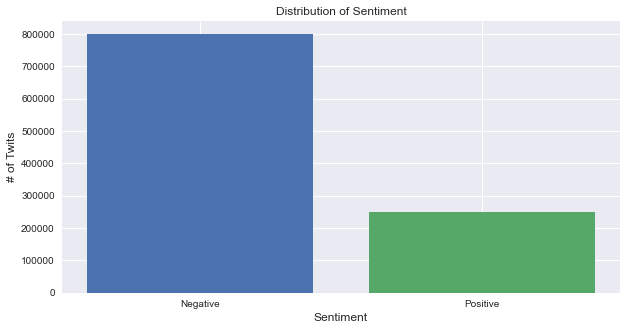

In [6]:
plt.figure(figsize=(10, 5))
plt.bar('Negative', len(df_spam[df_spam['polarity']==0]))
plt.bar('Positive', len(df_spam[df_spam['polarity']==1]))

plt.title('Distribution of Sentiment', size=12)
plt.xlabel('Sentiment', size=12)
plt.ylabel('# of Twits', size=12);

In [7]:
df_spam.text = df_spam.text.apply(remove_stopwords)
df_spam.text = df_spam.text.apply(normalize)
df_spam.tail()

,polarity,text
1048567,1,my grandma making dinenr mum
1048568,1,midmorning snack time bowl cheese noodles yum
1048569,1,shadela say like terminiator movies comes like...
1048570,1,destinyhope92 im great thaanks wbuu
1048571,1,cant wait til date weekend


In [8]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [9]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)
X = tfidf.fit_transform(df_spam['text'])
y = df_spam['polarity'].values

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

# Logistic Regression 

In [11]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [12]:
clf = LogisticRegression(C=5).fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/utkarshgoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8402355577807977

In [13]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.8402355577807977
              precision    recall  f1-score   support

           0       0.87      0.93      0.90    160000
           1       0.72      0.54      0.62     49715

    accuracy                           0.84    209715
   macro avg       0.79      0.74      0.76    209715
weighted avg       0.83      0.84      0.83    209715



In [14]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

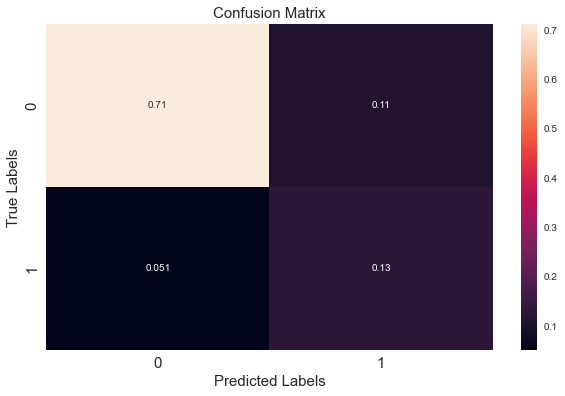

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

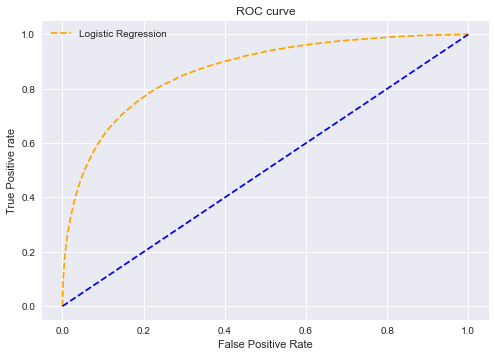

AUC score: 0.8662


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob1 = clf.predict_proba(X_test)

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show();

print('AUC score:',round(auc_score1, 4))

# Model

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [18]:
from sklearn.model_selection import train_test_split

X = df_spam['text']
y = df_spam['polarity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [19]:
vocab_size = 10000
embedding_dim = 64
max_length = 256
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

## tokenizer = Tokenizer(num_words=max_vocab)
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(embedding_dim),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      # tf.keras.metrics.Precision(name='precision'),
      # tf.keras.metrics.Recall(name='recall')
]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

In [22]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=100, shuffle=True, callbacks=[early_stop])

Epoch 1/10
8389/8389 [==============================] - 3930s 468ms/step - loss: 0.3910 - accuracy: 0.8238 - val_loss: 0.3627 - val_accuracy: 0.8319
Epoch 2/10
8389/8389 [==============================] - 3782s 451ms/step - loss: 0.3549 - accuracy: 0.8397 - val_loss: 0.3525 - val_accuracy: 0.8397
Epoch 3/10
8389/8389 [==============================] - 3781s 451ms/step - loss: 0.3467 - accuracy: 0.8435 - val_loss: 0.3505 - val_accuracy: 0.8429
Epoch 4/10
8389/8389 [==============================] - 3786s 451ms/step - loss: 0.3415 - accuracy: 0.8455 - val_loss: 0.3492 - val_accuracy: 0.8412
Epoch 5/10
8389/8389 [==============================] - 3865s 461ms/step - loss: 0.3370 - accuracy: 0.8474 - val_loss: 0.3492 - val_accuracy: 0.8432
Epoch 6/10
8389/8389 [==============================] - 4016s 479ms/step - loss: 0.3327 - accuracy: 0.8496 - val_loss: 0.3484 - val_accuracy: 0.8434
Epoch 7/10
8389/8389 [==============================] - 3709s 442ms/step - loss: 0.3282 - accuracy: 0.8519

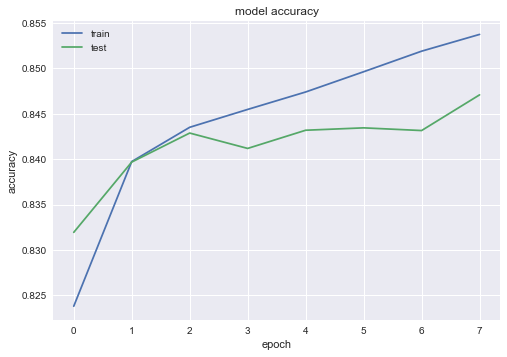

In [32]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

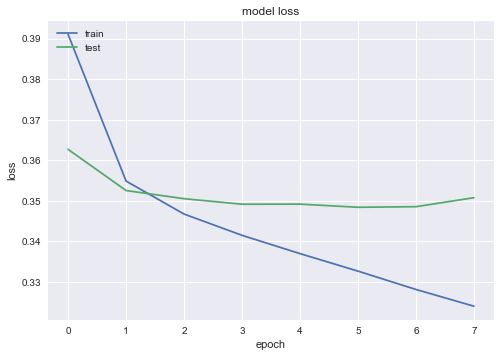

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)

6554/6554 [==============================] - 421s 64ms/step


In [28]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [29]:
print("---Test Set Results---")
print("Accuracy with LSTM: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

---Test Set Results---
Accuracy with LSTM: 0.8434399065398278
              precision    recall  f1-score   support

           0       0.85      0.97      0.90    160000
           1       0.82      0.43      0.57     49715

    accuracy                           0.84    209715
   macro avg       0.83      0.70      0.74    209715
weighted avg       0.84      0.84      0.82    209715



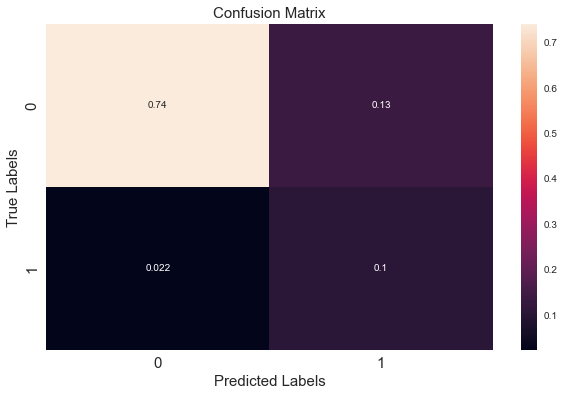

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

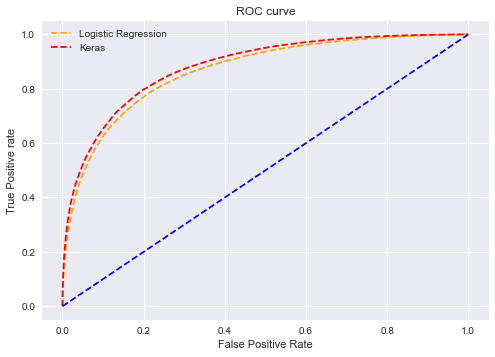

AUC score: 0.8816


In [31]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_score1 = auc(fpr_keras, tpr_keras)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_keras, tpr_keras, linestyle='--',color='red', label='Keras')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

print('AUC score:',round(auc_score1, 4))